## Описание Данных

- **Марка и модель автомобиля:** Категориальные данные, определяющие производителя и конкретную модель автомобиля (например, “Toyota Camry”, “BMW X5”).
- **Год выпуска:** Числовые данные, представляющие год производства автомобиля.
- **Пробег:** Числовые данные, указывающие общее расстояние, пройденное автомобилем (обычно в километрах или милях).
- **Тип кузова:** Категориальные данные, описывающие тип кузова автомобиля (например, “седан”, “хэтчбек”, “внедорожник”, “пикап”).
- **Объем двигателя:** Числовые данные, указывающие объем двигателя в литрах или кубических сантиметрах.
- **Тип двигателя:** Категориальные данные, определяющие тип используемого двигателя (“бензин”, “дизель”, “гибрид”, “электро”).
- **Мощность двигателя:** Числовые данные, показывающие мощность двигателя в лошадиных силах (л.с.) или киловаттах (кВт).
- **Коробка передач:** Категориальные данные, описывающие тип коробки передач (“автомат”, “механика”, “вариатор”).
- **Цена:** Числовые данные, указывающие стоимость автомобиля (в выбранной валюте).

In [86]:
#Импортируем библиотеки
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
plt.figure(figsize=(11,20));

<Figure size 1100x2000 with 0 Axes>

#### Обработка и Очистка Данных

In [90]:
#Указываем путь к JSON файлу с данными
url = '/home/max/git/maxtyrsa-1/Анализ рынка подержанных автомобилей: парсинг данных с carro.ru/carro.json'

#Загружаем JSON данные из указанного файла в DataFrame
carro = pd.read_json(url)

#Выпрямляем вложенные данные из поля 'tech_specs'
tech = pd.json_normalize(carro['tech_specs'])

# Удаляем исходное поле 'tech_specs' из DataFrame
carro = carro.drop('tech_specs', axis=1)

#Объединяем исходный DataFrame с выпрямленными данными
carro = pd.concat([carro, tech], axis=1)

In [91]:
#Приведение названий столбцов к общему стилю
carro.rename(columns={'Год:': 'year', 'Коробка:': 'transmission', 'Пробег:': 'mileage', 'Объем:': 'volume', 'Мощность:': 'power', 'Двигатель:': 'engine', 'Тип кузова:': 'body_type', 'Привод:': 'drive', 'Владельцы:': 'owners'}, inplace=True)

In [92]:
# Посмотрим типы данных
carro.dtypes

name            object
price           object
url             object
year            object
transmission    object
mileage         object
volume          object
power           object
engine          object
body_type       object
drive           object
owners          object
dtype: object

In [93]:
#Преобразуем столбец year в datetime и вычислик количество лет автомобилей в годах и добавим столбец age
carro['year'] = carro.year.astype('int')
carro['age'] = pd.to_datetime('now').year - carro.year

In [94]:
# Добавим строки с названием и моделью автомобилей
carro['brand'] = carro.url.str.split('/').str[5]
carro['model'] = carro.url.str.split('/').str[6]

In [95]:
# Применение регулярных выражений для замены значений
carro['price'] = carro['price'].str.replace(r'\D+', '', regex=True).astype('int')
carro['mileage'] = carro['mileage'].str.replace(r'\D+', '', regex=True).astype('int')
carro['volume'] = carro['volume'].str.replace(' л', '').str.replace('\xa0', '').astype('float')
carro['power'] = carro['power'].str.replace(r'\D+', '', regex=True).astype('int')

In [96]:
# Удалим колонку URL
carro.drop(columns=['url'], axis=1, inplace=True)

In [97]:
carro.head()

,name,price,year,transmission,mileage,volume,power,engine,body_type,drive,owners,age,brand,model
0,"Peugeot 308 1.6 AT, 2010, 145 543 км",299000,2010,AT,145543,1.6,120,Бензин,Хэтчбек 5 дв.,Передний,2 владельца,14,peugeot,308
1,"Chevrolet Cruze 1.6 MT, 2012, 180 066 км",399000,2012,MT,180066,1.6,109,Бензин,Седан,Передний,2 владельца,12,chevrolet,cruze
2,"Lifan X60 1.8 MT, 2013, 137 622 км",399000,2013,MT,137622,1.8,128,Бензин,Внедорожник 5 дв.,Передний,1 владелец,11,lifan,x60
3,"LADA (ВАЗ) Largus 1.6 MT, 2015, 117 128 км",419000,2015,MT,117128,1.6,105,Бензин,Универсал 5 дв.,Передний,2 владельца,9,lada-vaz,largus
4,"Great Wall Hover H5 2.4 MT, 2013, 140 844 км",419000,2013,MT,140844,2.4,127,Бензин,Внедорожник 5 дв.,Полный,2 владельца,11,great-wall,hover-h5


In [98]:
# проверка на пропуски
carro.isna().sum()

name            0
price           0
year            0
transmission    0
mileage         0
volume          0
power           0
engine          0
body_type       0
drive           0
owners          0
age             0
brand           0
model           0
dtype: int64

In [99]:
# проверка на дубликаты
carro.duplicated().sum()

0

#### Общая статистика

In [102]:
#Посмотрим общую информацию о структуре данных 
carro.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9921 entries, 0 to 9920
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   name          9921 non-null   object 
 1   price         9921 non-null   int64  
 2   year          9921 non-null   int64  
 3   transmission  9921 non-null   object 
 4   mileage       9921 non-null   int64  
 5   volume        9921 non-null   float64
 6   power         9921 non-null   int64  
 7   engine        9921 non-null   object 
 8   body_type     9921 non-null   object 
 9   drive         9921 non-null   object 
 10  owners        9921 non-null   object 
 11  age           9921 non-null   int64  
 12  brand         9921 non-null   object 
 13  model         9921 non-null   object 
dtypes: float64(1), int64(5), object(8)
memory usage: 1.1+ MB


In [104]:
# Выведим сводную статистику всех числовых столбцов
carro.describe()

,price,year,mileage,volume,power,age
count,9.921000e+03,9921.000000,9921.000000,9921.000000,9921.000000,9921.000000
mean,1.341898e+06,2014.411551,120228.247354,2.448100,202.915634,9.588449
std,6.810405e+05,3.508208,42286.211396,0.878504,72.637462,3.508208
min,2.990000e+05,2004.000000,7.000000,1.000000,80.000000,0.000000
25%,8.690000e+05,2012.000000,90968.000000,2.000000,150.000000,7.000000
50%,1.179000e+06,2014.000000,127534.000000,2.100000,184.000000,10.000000
75%,1.589000e+06,2017.000000,149650.000000,3.000000,245.000000,12.000000
max,6.999000e+06,2024.000000,373018.000000,6.200000,575.000000,20.000000


#### Уникальные значения

In [106]:
carro.body_type.value_counts()

body_type
Внедорожник 5 дв.       5050
Седан                   2996
Минивэн                  434
Лифтбек                  394
Хэтчбек 5 дв.            344
Универсал 5 дв.          343
Компактвэн               108
Пикап Двойная кабина      79
Купе                      76
Купе-хардтоп              44
Хэтчбек 3 дв.             35
Внедорожник 3 дв.         18
Name: count, dtype: int64

In [107]:
carro.transmission.value_counts()

transmission
AT     7222
AMT    1418
CVT     938
MT      343
Name: count, dtype: int64

In [113]:
carro.engine.value_counts()

engine
Бензин    6923
Дизель    2995
Гибрид       3
Name: count, dtype: int64

In [114]:
carro.owners.value_counts()

owners
2 владельца     4906
1 владелец      4606
3 владельца      305
Новый             71
4 владельца       28
5 владельцев       3
0 владельцев       2
Name: count, dtype: int64

**Тип кузова:** На рынке доминируют 5-дверные внедорожники, за которыми следуют седаны. Существует также широкий выбор других типов кузова, многие из которых менее распространены.

**Трансмиссия:** Автоматические коробки передач являются наиболее распространенным типом, что говорит об общем предпочтении именно этого типа трансмиссии.

**Двигатель:** Бензиновые двигатели являются наиболее распространенными, их используют в значительном количестве дизельные автомобили и очень мало гибридов.

**Владельцы:** Большинство транспортных средств в наборе данных принадлежали одному или двум предыдущим владельцам. Новых автомобилей немного, а те, у которых больше владельцев, встречаются очень редко.

#### Визуализация

/tmp/ipykernel_15978/2117569004.py:4: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  carro.hist(ax = ax);


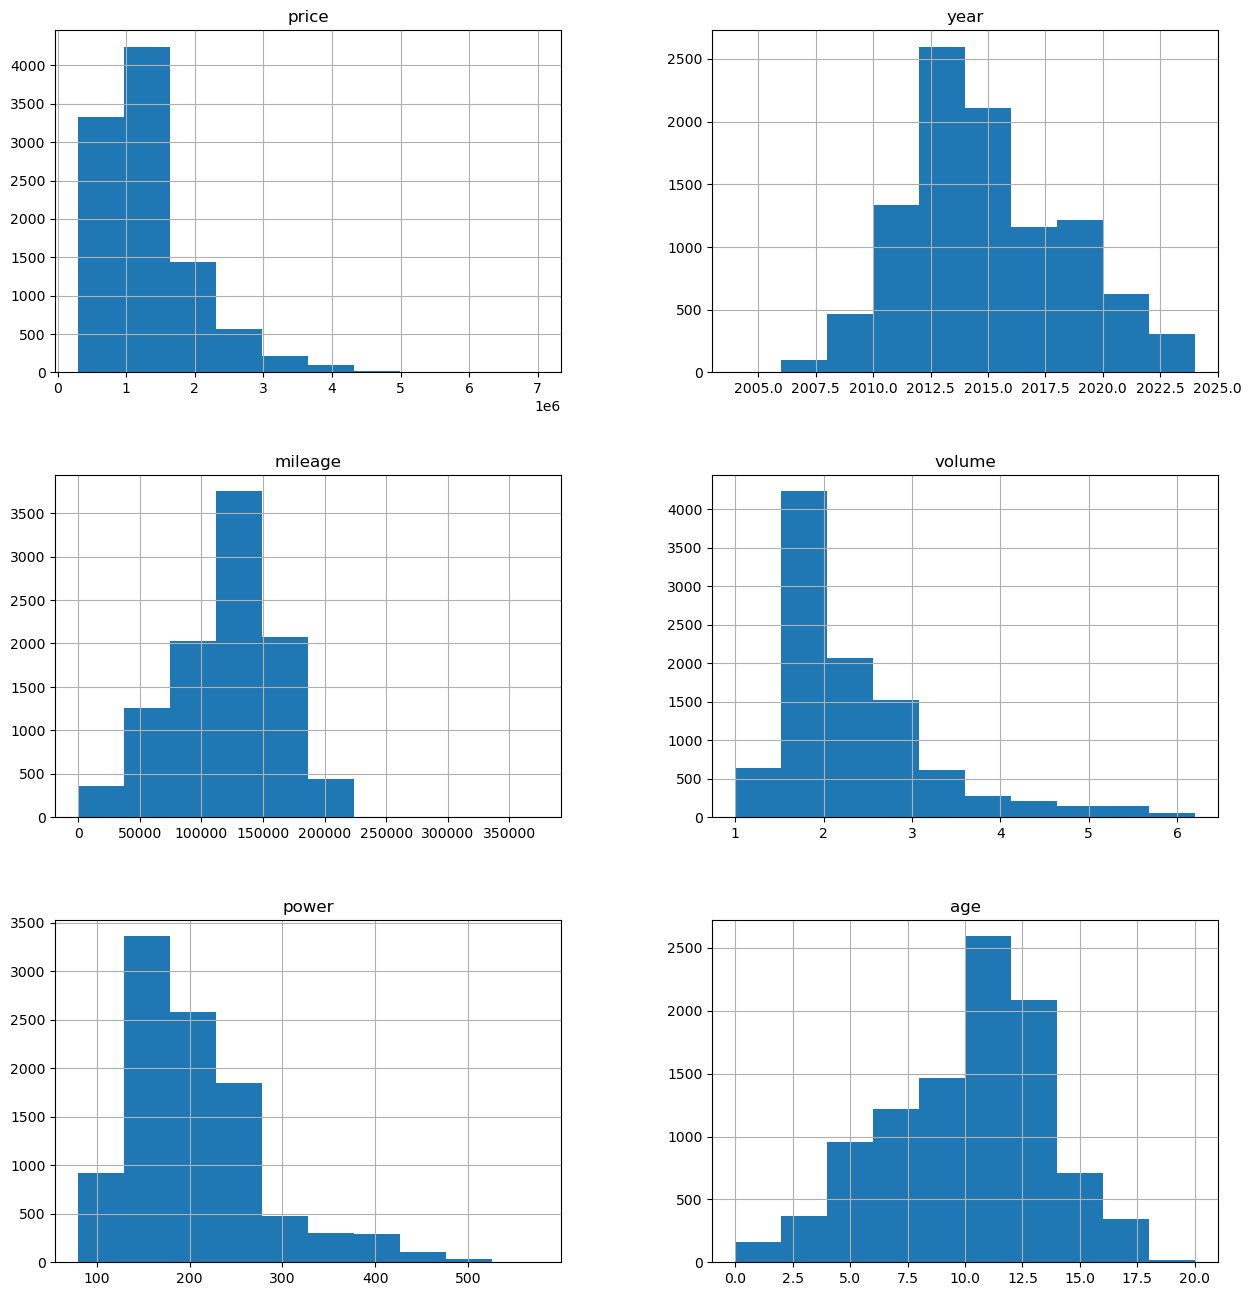

In [105]:
# Создадим гистограмму данных и посмотрим распределения данных
fig = plt.figure(figsize = (15,16))
ax = fig.gca()
carro.hist(ax = ax);

**Цена:** большинство автомобилей относительно недорогие, но есть и некоторые дорогие автомобили, которые встречаются реже.

**Год:** В наборе данных в значительной степени представлены автомобили, произведенные в начале-середине 2010-х годов.

**Пробег:** большинство автомобилей имеют умеренный пробег, а у небольшого количества автомобилей пробег может быть либо очень маленьким, либо очень большим.

**Объем:** Большинство автомобилей имеют относительно небольшой объем двигателя, и лишь немногие автомобили имеют большие двигатели.

**Мощность:** Большинство транспортных средств, представленных в данных, имеют выходную мощность менее 200 лошадиных сил.

**Возраст:** возраст автомобилей в наборе данных составляет от 10 до 15 лет.

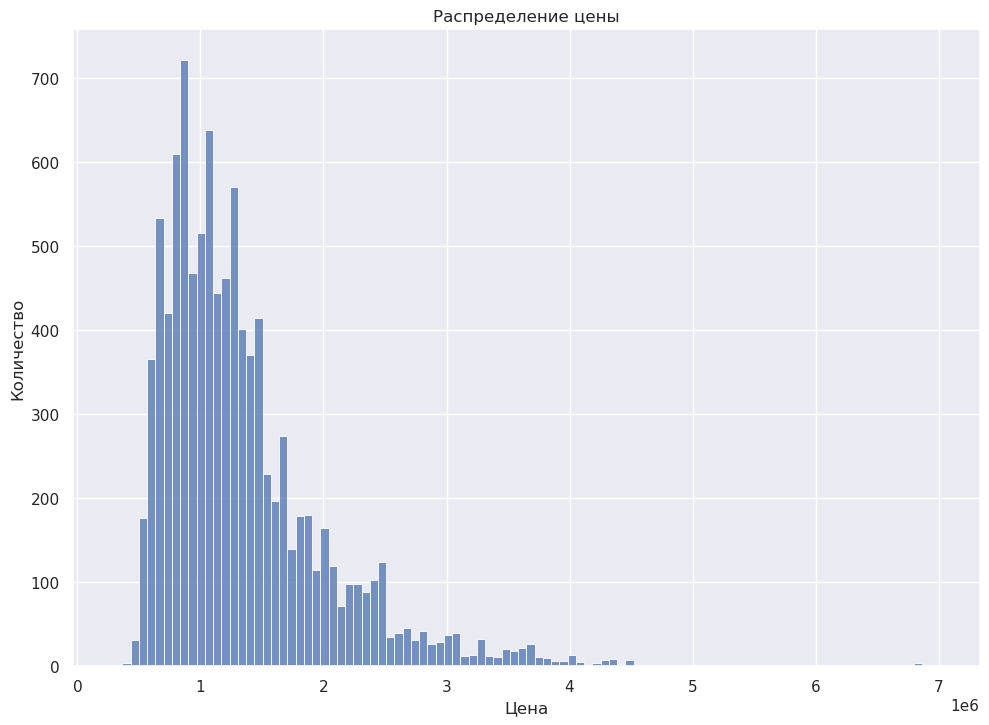

<Figure size 1900x600 with 0 Axes>

In [124]:
sns.histplot(carro['price'])
plt.xlabel('Цена')
plt.ylabel('Количество')
plt.title('Распределение цены')
plt.figure(figsize=(19,6))
plt.show()


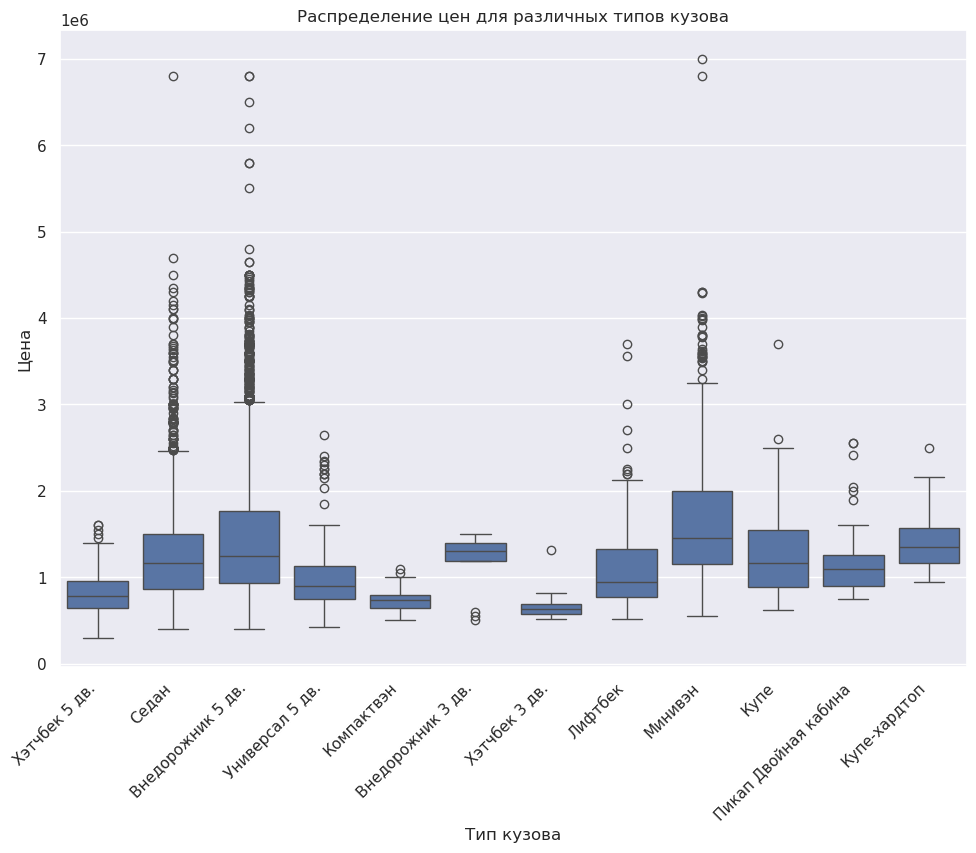

<Figure size 1900x600 with 0 Axes>

In [129]:
sns.boxplot(x='body_type', y='price', data=carro)
plt.xticks(rotation=45, ha='right')
plt.xlabel('Тип кузова')
plt.ylabel('Цена')
plt.title('Распределение цен для различных типов кузова')
plt.figure(figsize=(19,6))
plt.show()

**Диапазон цен:** Существует широкий диапазон цен для разных типов телосложения. Некоторые типы имеют узкий диапазон цен, в то время как другие более изменчивы.

**Тенденции средних цен:** самые высокие средние цены у 5-дверных внедорожников и минивэнов. Хэтчбеки, компактные фургоны и 3-дверные внедорожники имеют более низкие средние цены. Седаны, универсалы, пикапы, купе и лифтбеки находятся посередине.

**Наличие аномальных моделей:** седаны, 5-дверные внедорожники и минивэны демонстрируют большее количество аномальных моделей высокого класса, что указывает на то, что автомобили премиум-класса в этих классах встречаются часто.

**Изменчивость цен:** некоторые типы кузова (например, седаны, 5-дверные внедорожники, минивэны) имеют широкий диапазон цен, в то время как другие более постоянны.

In [132]:
corr = carro[['volume', 'mileage', 'price', 'year', 'power', 'age']].corr()

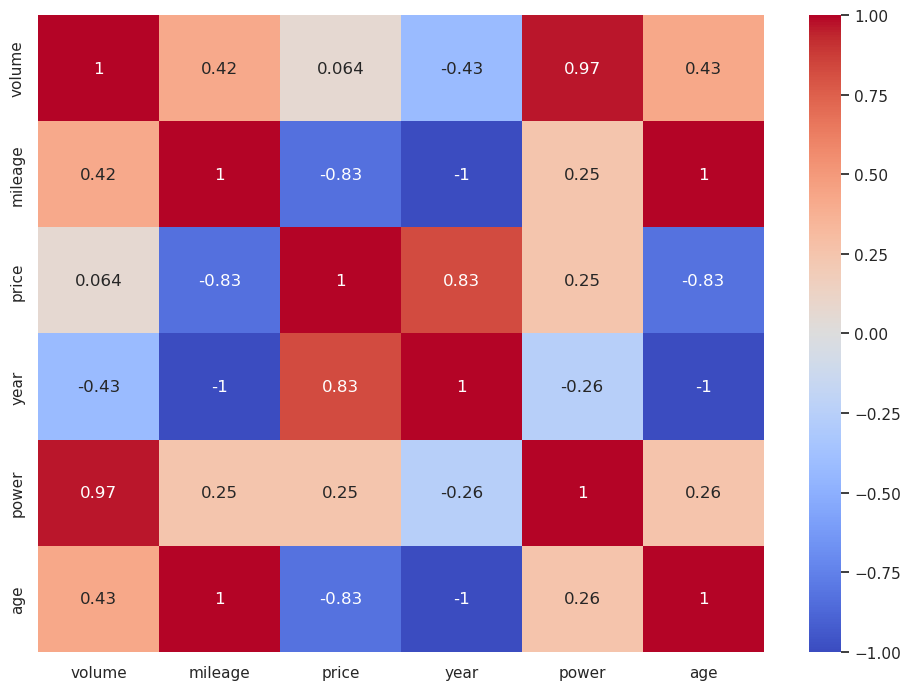

In [133]:
sns.heatmap(corr.corr(), annot=True, cmap='coolwarm')
plt.show()

##### Сильные положительные корреляции:

**Volume и Power:** Сильная положительная корреляция предполагает, что больший объем двигателя тесно связан с мощностью двигателя.

**Year и Price:** более новые автомобили, как правило, имеют значительно более высокие цены, что интуитивно понятно.

**Mileage и Age:** Это идеальная положительная связь, поскольку возраст автомобиля определяется по году выпуска, а пробег напрямую зависит от возраста автомобиля.

##### Сильные отрицательные корреляции:

**Mileage и Price:** больший пробег тесно связан с более низкими ценами, что отражает влияние эксплуатации на стоимость автомобиля.

**Mileage и Year:** У новых автомобилей пробег меньше.

**Age и Price:** Старые автомобили, как правило, имеют более низкую цену.

**Age и Year:** Это идеальная отрицательная связь, поскольку возраст автомобиля можно определить по году его выпуска.

##### Слабые корреляции:

**Volume и Price:** Очень слабая корреляция, что говорит о том, что объем не является основным фактором при определении цены.

**Power и Price:** Слабая положительная корреляция, предполагающая, что власть оказывает незначительное влияние на цену.

#### Анализ по марке и модели

In [138]:
average_price_by_model = carro.groupby('model')['price'].mean().sort_values(ascending=False)

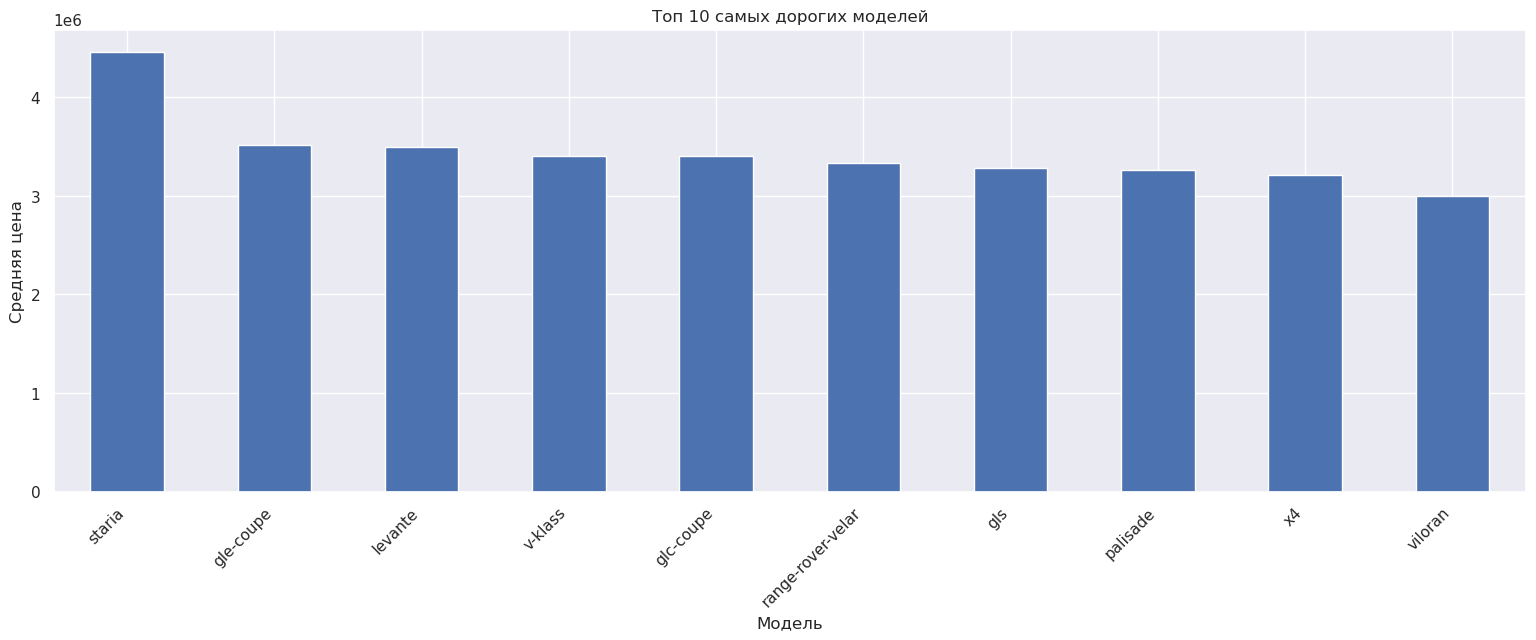

In [152]:
plt.figure(figsize=(19,6))
average_price_by_model.head(10).plot(kind='bar')
plt.title('Топ 10 самых дорогих моделей')
plt.ylabel('Средняя цена')
plt.xlabel('Модель')
plt.xticks(rotation=45, ha='right')
plt.show()

In [142]:
average_price_by_brand = carro.groupby('brand')['price'].mean().sort_values(ascending=False)

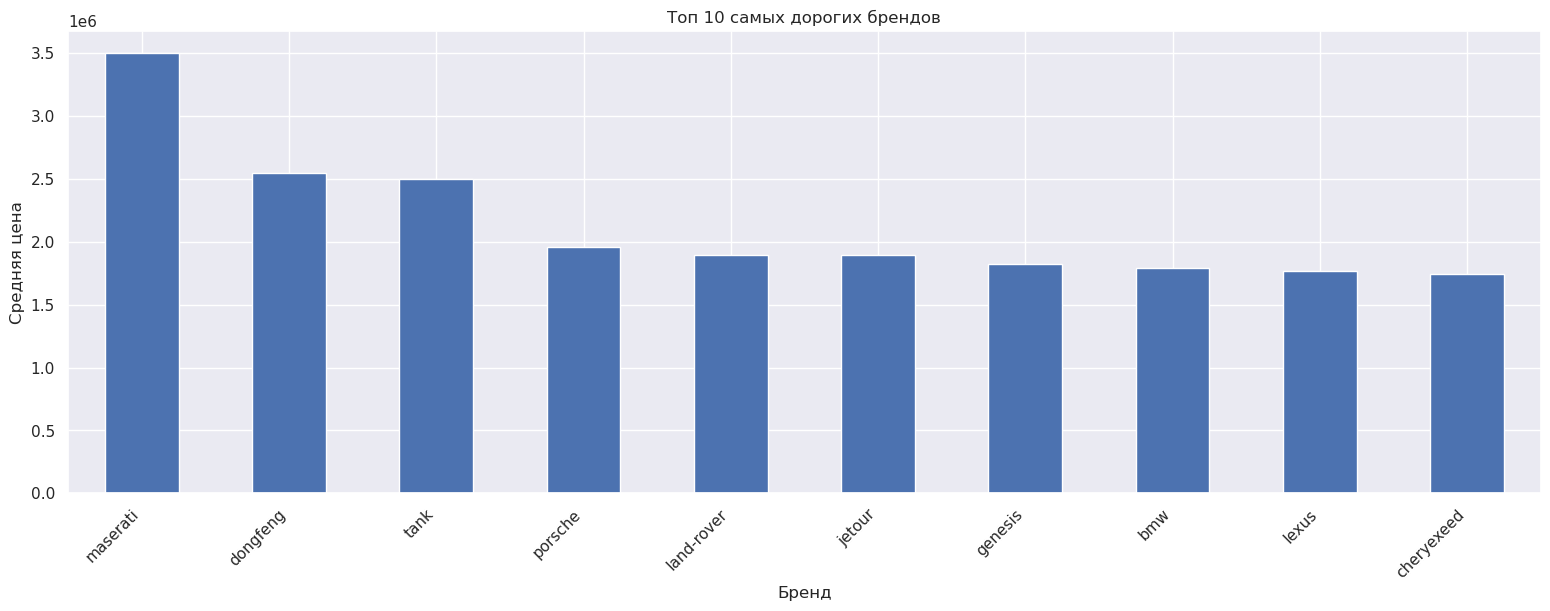

In [147]:
plt.figure(figsize=(19,6))
average_price_by_brand.head(10).plot(kind='bar')
plt.title('Топ 10 самых дорогих брендов')
plt.ylabel('Средняя цена')
plt.xlabel('Бренд')
plt.xticks(rotation=45, ha='right')
plt.show()

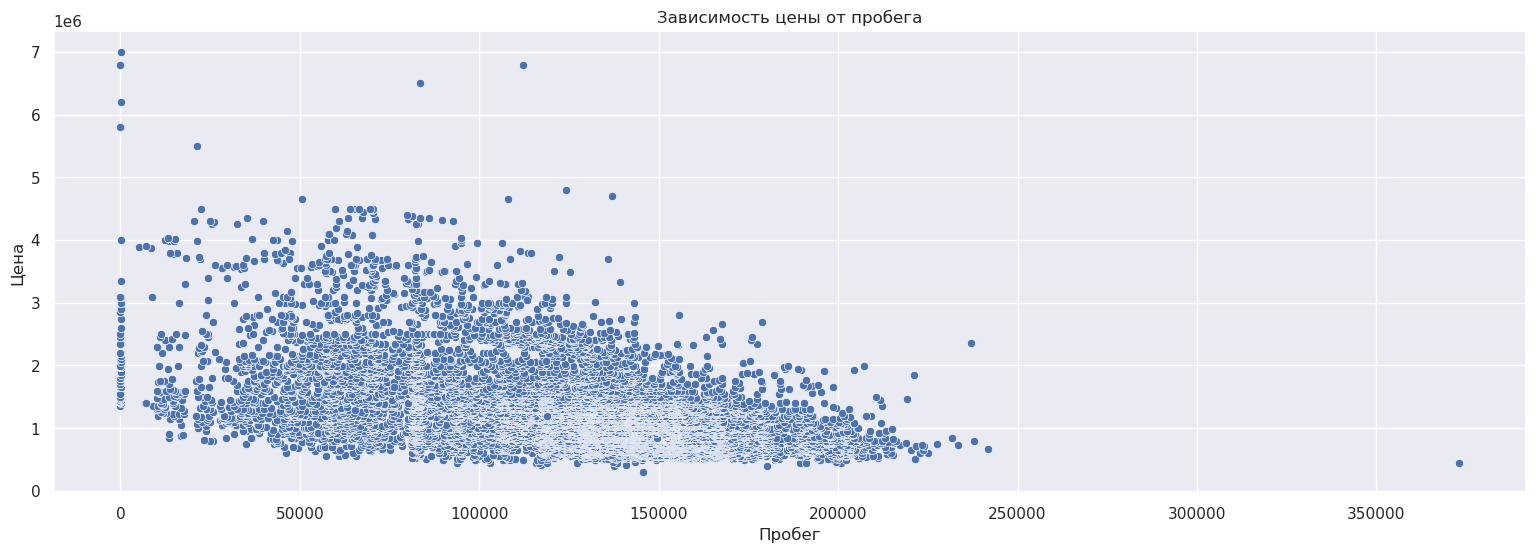

In [150]:
# Диаграмма рассеяния
plt.figure(figsize=(19,6))
sns.scatterplot(x='mileage', y='price', data=carro)
plt.title('Зависимость цены от пробега')
plt.ylabel('Цена')
plt.xlabel('Пробег')
plt.show()


**Снижение цены с пробегом:** по мере того, как автомобили становятся старше и на них больше ездят, их цены обычно снижаются. Эта зависимость нелинейна; первоначальное снижение становится гораздо более резким по мере того, как автомобиль начинает использоваться.

**Большой разброс цен при небольшом пробеге:** тот факт, что существуют автомобили с небольшим пробегом и высокой ценой, а также автомобили с низкой ценой, говорит о том, что важным фактором при определении цены являются и другие переменные, помимо пробега.

**Пробег как основной фактор:** По мере увеличения пробега диапазон цен сужается и снижается, что говорит о том, что пробег является важной переменной.

**Выбросы:** Наличие выбросов свидетельствует о том, что некоторые транспортные средства не соответствуют общей тенденции и поэтому требуют дополнительной проверки.

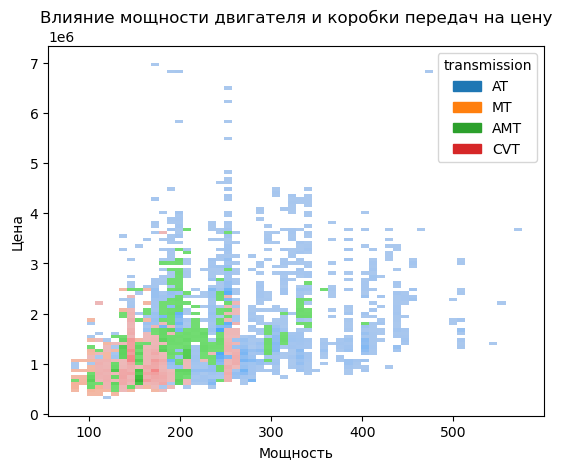

In [25]:
sns.histplot(data=carro, x='power', y='price', hue='transmission');
plt.title('Влияние мощности двигателя и коробки передач на цену');
plt.xlabel('Мощность');
plt.ylabel('Цена');
sns.set_theme(rc={'figure.figsize':(11.7,8.27)})


##### Общая тенденция: 
наблюдается общая тенденция к росту, предполагающая, что с ростом мощности двигателя цена также имеет тенденцию к росту. Это ожидаемо.

##### 
Тип трансмиссии: Различные цвета позволяют сравнивать цену и мощность для разных типов трансмиссии. Вы можете увидеть, какие типы трансмиссии более распространены при разных уровнях мощности и цены. Например, кажется, что автоматические трансмиссии (AT) более распространены в более высоких ценовых диапазонах и с более высокой выходной мощностью.

##### Кластеризация: 
Точки данных распределены неравномерно, что подразумевает кластеризацию схожих автомобилей на основе цены и мощности. Определенные комбинации мощности и цены встречаются чаще, чем другие.

##### Выбросы: 
некоторые точки данных разбросаны в областях с более низкой плотностью, что потенциально указывает на выбросы (транспортные средства с необычными сочетаниями цены и мощности для своего типа трансмиссии).

In [83]:
name_count = carro.groupby('name', as_index=False).agg({'price': 'count'}).sort_values('price', ascending=False)

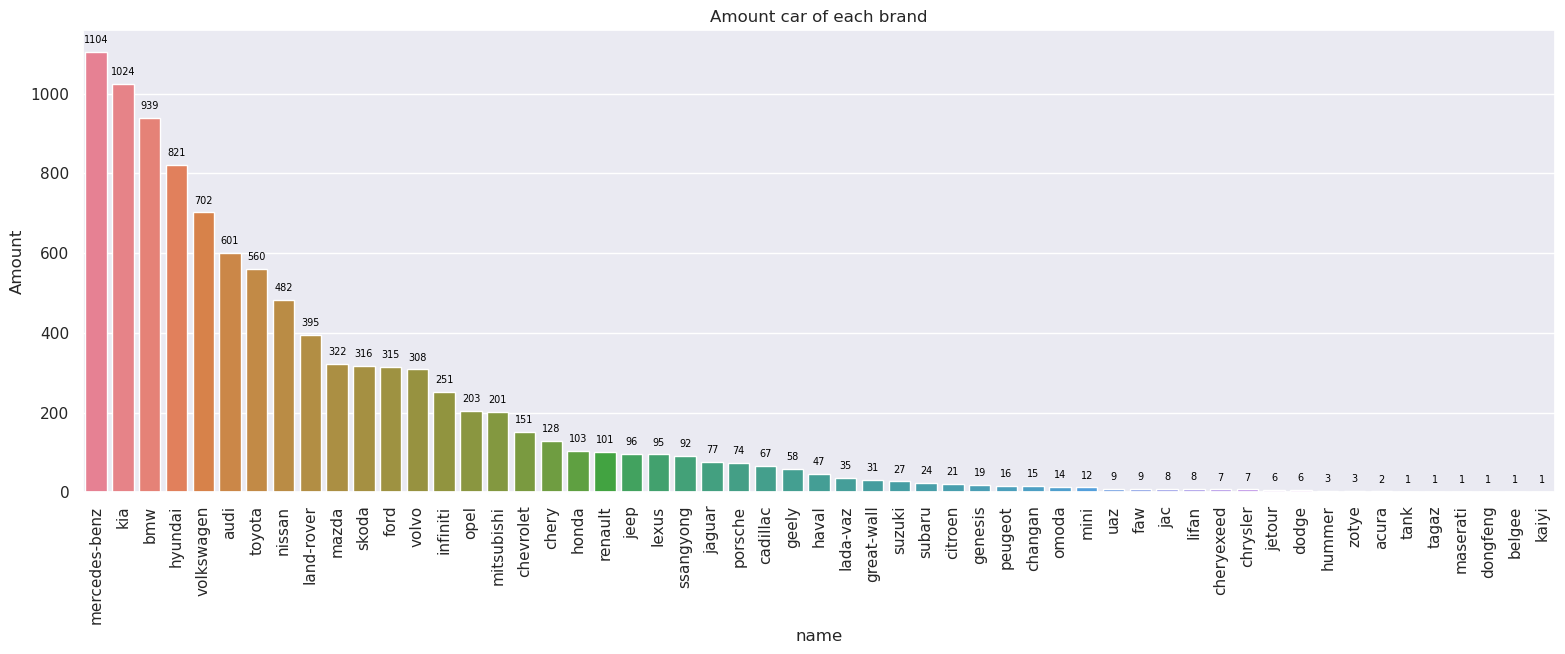

In [84]:
plt.figure(figsize=(19,6))
ax = sns.barplot(data = name_count, x = 'name', y = 'price', hue = 'name' )
plt.xticks(rotation = 90)
for p in ax.patches:
    ax.annotate(f'{p.get_height():.0f}',
                (p.get_x() + p.get_width() / 2, p.get_height()),
                ha='center', va='bottom',
                fontsize=7, color='black', xytext=(0, 5), textcoords='offset points')
plt.ylabel('Amount')
plt.title('Amount car of each brand')
plt.show();

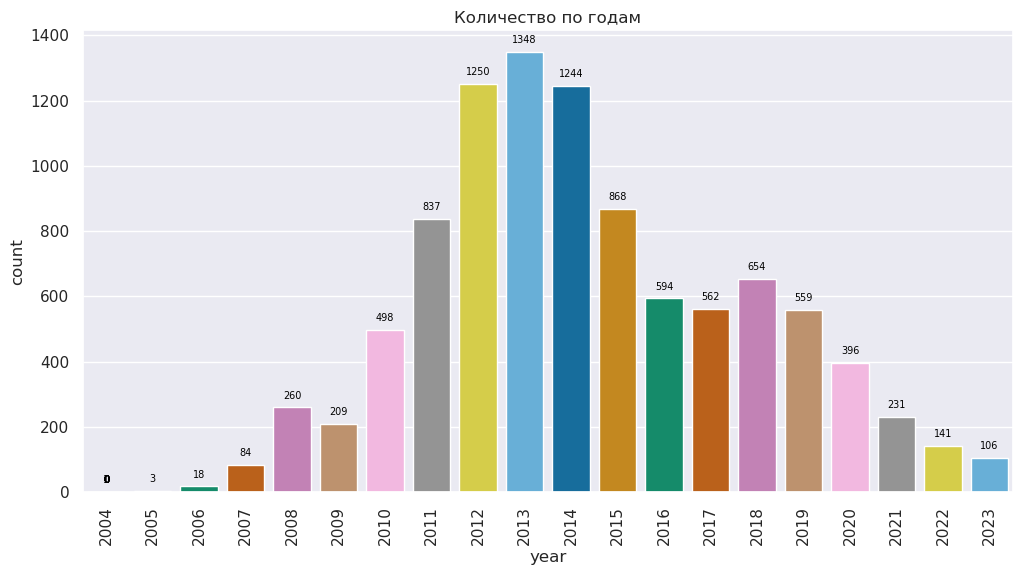

In [85]:
#year
#first group and count eachn year and list full year started min to max
year_counts = carro['year'].value_counts()
year_sorted_df = year_counts.reset_index().sort_values(by ='year') #change to dataframe and sort
all_years = list(range(year_sorted_df['year'].min(), year_sorted_df['year'].max())) #make array full year min to max
df_full = pd.DataFrame({'year': all_years}) #create dataframe (column year full)
df_full = df_full.merge(year_sorted_df, on='year', how='left') #merge 2 dataframe
df_full['Count'] = df_full['count'].fillna(0).astype(int) #fill NaN by 0
df_full.drop(columns=['count']) #drop count column
plt.figure(figsize=(12,6))
ax = sns.barplot(data = df_full, x = 'year', y = 'count', palette = 'colorblind', hue = 'year')
plt.xticks(rotation = 90)
for p in ax.patches:
    ax.annotate(f'{p.get_height():.0f}',
                (p.get_x() + p.get_width() / 2, p.get_height()),
                ha='center', va='bottom',
                fontsize=7, color='black', xytext=(0, 5), textcoords='offset points')
plt.legend().set_visible(False) # tắt chú thích
plt.title('Количество по годам')
plt.show();

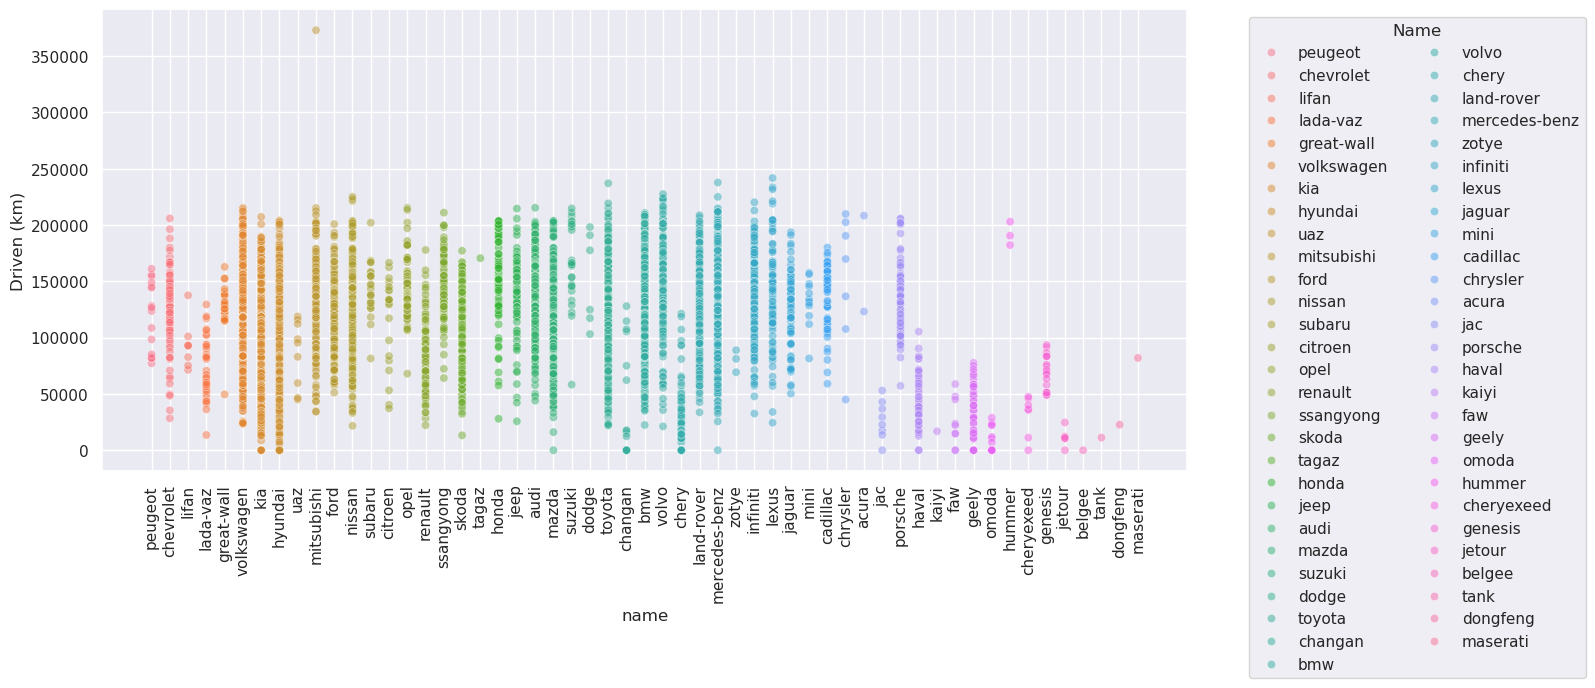

In [86]:
plt.figure(figsize=(14,6))
sns.scatterplot(data = carro,  x = 'name', y = 'mileage', hue = 'name', alpha = 0.5)
plt.legend(title="Name", bbox_to_anchor=(1.05, 1), loc='upper left',ncol = 2) #chú thích ra ngoài và 2 cột
plt.xticks(rotation = 90)
plt.ylabel('Driven (km)')
plt.show();

## Корреляция

In [66]:
corr = carro[['volume', 'mileage', 'price', 'year', 'power', 'age']].corr()

In [70]:
corr

,volume,mileage,price,year,power,age
volume,1.000000,0.293875,0.338396,-0.301244,0.862301,0.301244
mileage,0.293875,1.000000,-0.469223,-0.983659,0.203461,0.983659
price,0.338396,-0.469223,1.000000,0.473645,0.436797,-0.473645
year,-0.301244,-0.983659,0.473645,1.000000,-0.211535,-1.000000
power,0.862301,0.203461,0.436797,-0.211535,1.000000,0.211535
age,0.301244,0.983659,-0.473645,-1.000000,0.211535,1.000000


In [67]:
x_age = carro.age
y_mileage = carro.mileage
x_power = carro.power
y_volume = carro.volume

In [68]:
 
def Pearson_correlation(X,Y):
    if len(X)==len(Y):
        Sum_xy = sum((X-X.mean())*(Y-Y.mean()))
        Sum_x_squared = sum((X-X.mean())**2)
        Sum_y_squared = sum((Y-Y.mean())**2)       
        corr = Sum_xy / np.sqrt(Sum_x_squared * Sum_y_squared)
    return corr
             
print('Кореляция Возраста машины и Пробега')
print(Pearson_correlation(x_age, y_mileage))    
print(Pearson_correlation(x_age, x_age))
print('Кореляция Мощьности и обьема двигатля')
print(Pearson_correlation(x_power, y_volume))    
print(Pearson_correlation(x_power, x_power))

Кореляция Возраста машины и Пробега
0.9836585351725121
1.0
Кореляция Мощьности и обьема двигатля
0.8623007599482589
1.0


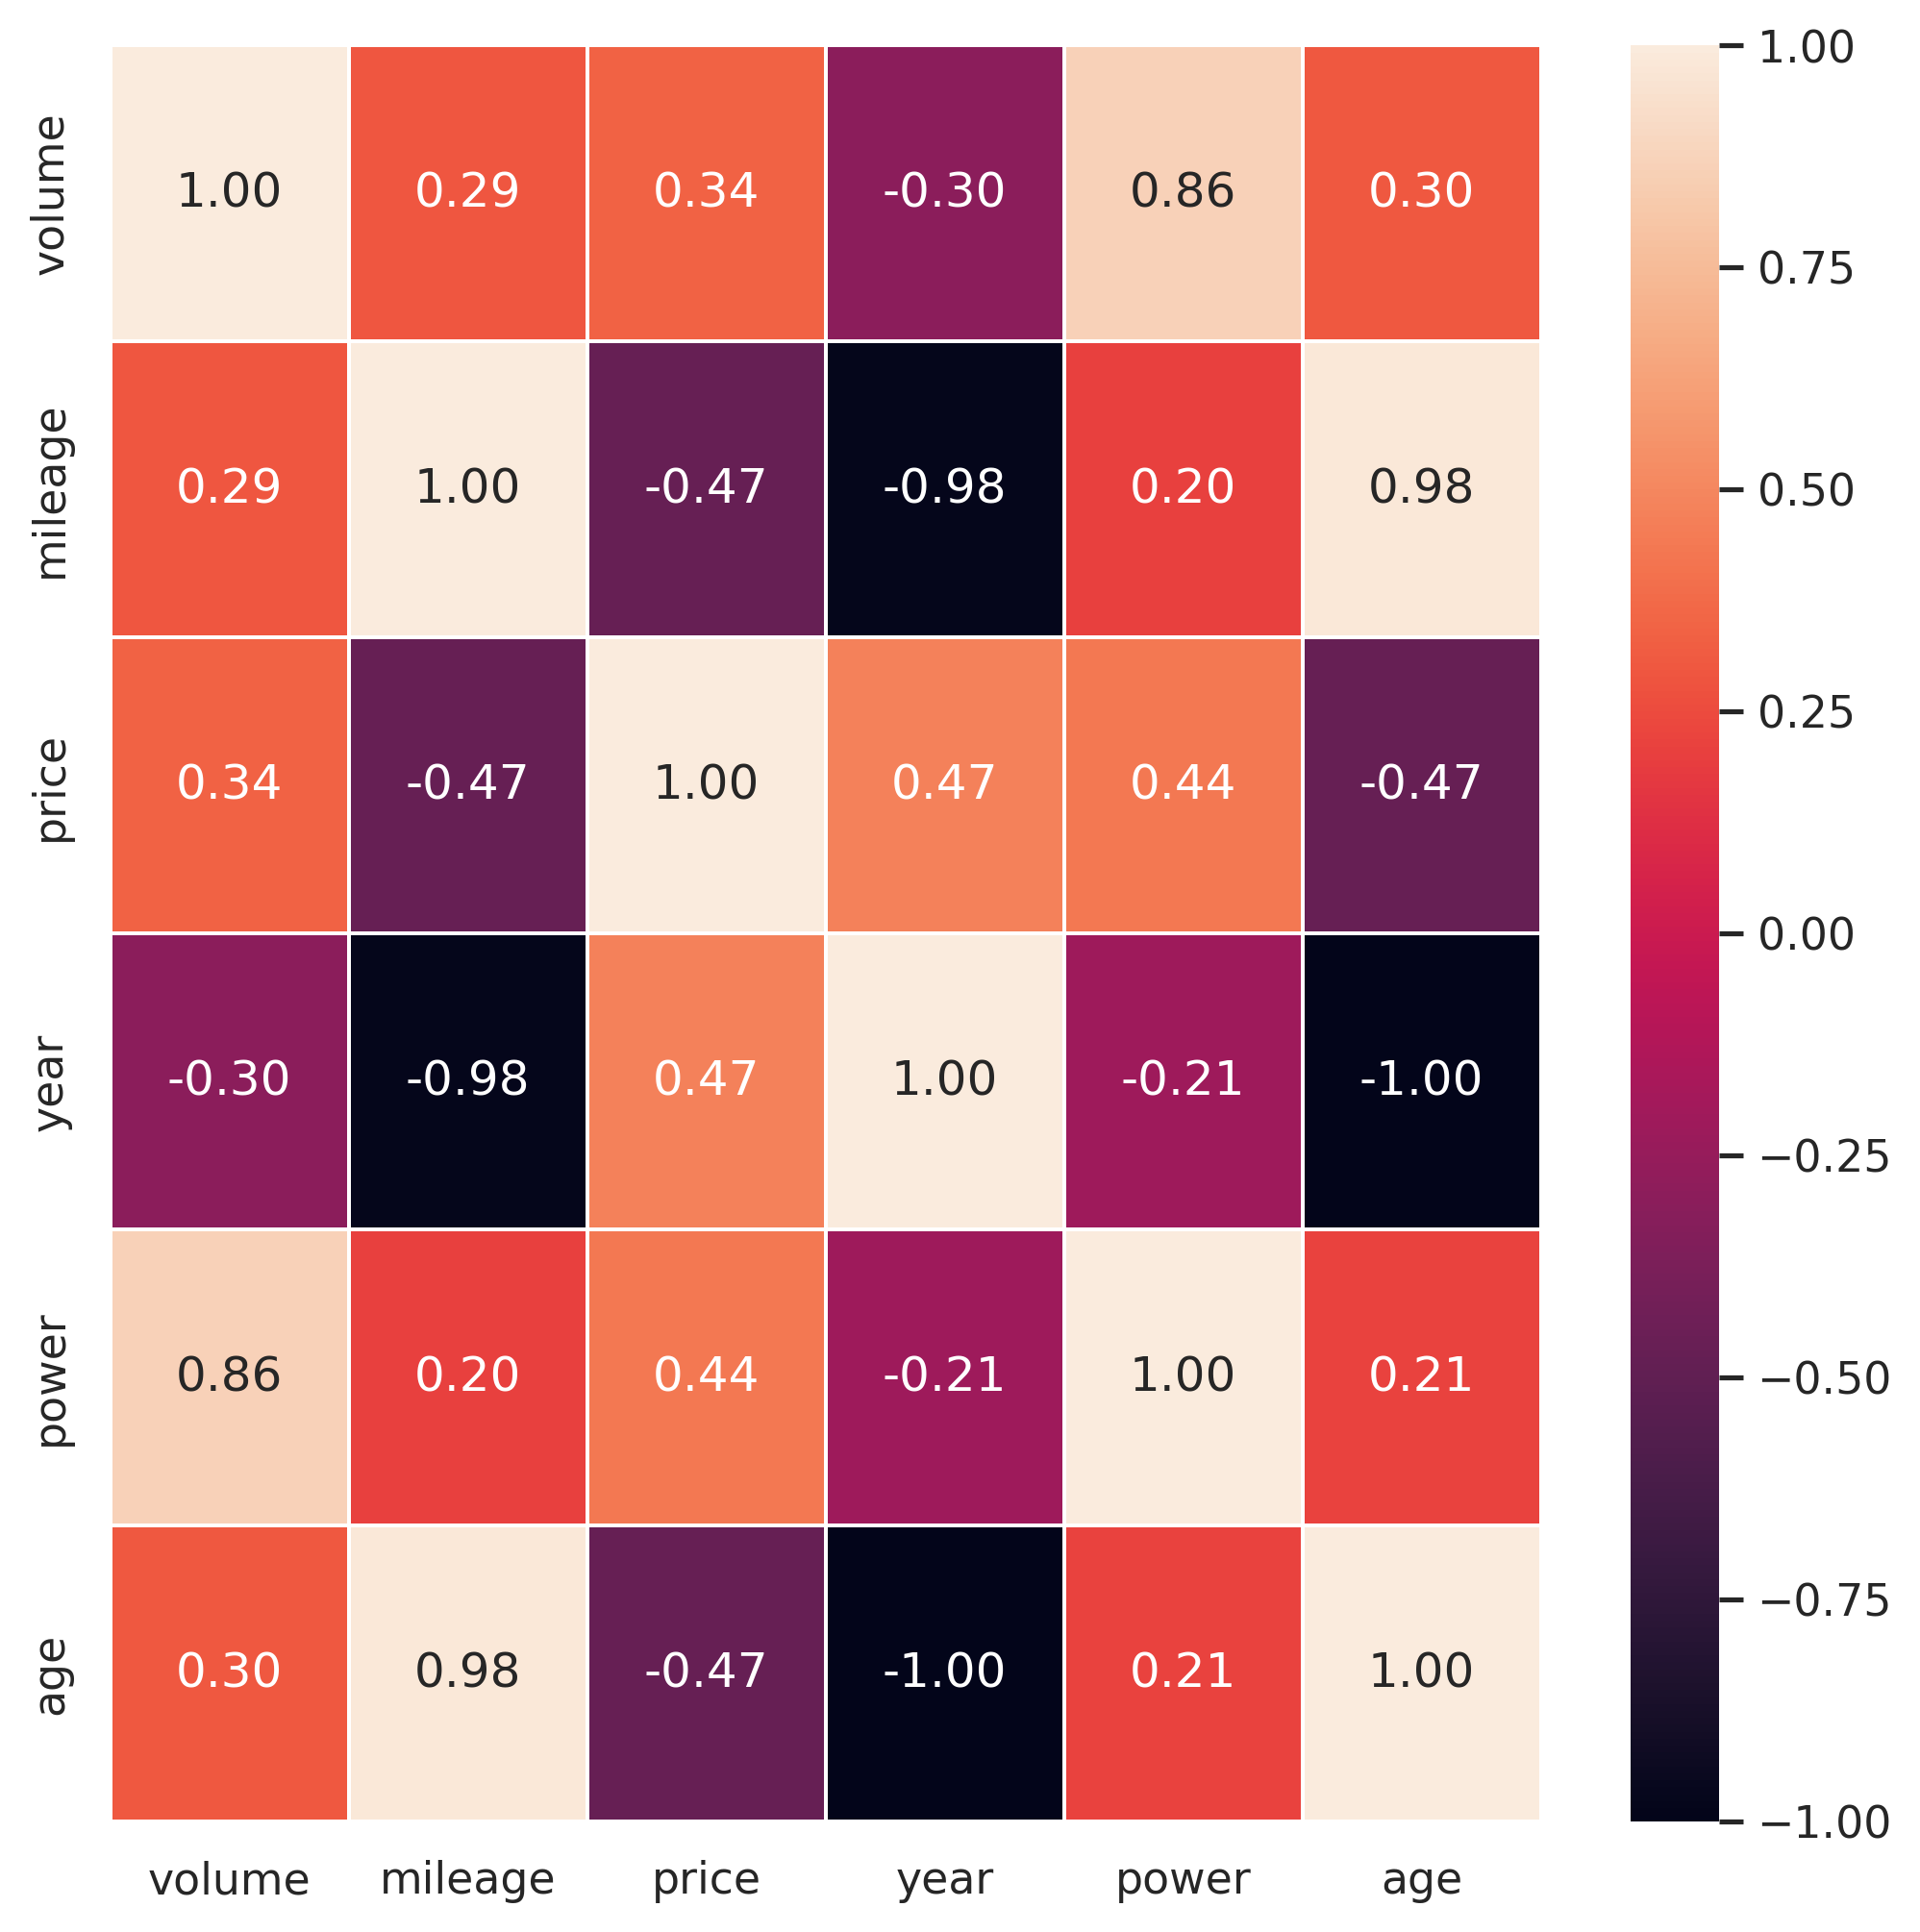

In [69]:
plt.figure(figsize=(8,8), dpi =300)
sns.heatmap(corr,annot=True,fmt=".2f", linewidth=.5)
plt.show()

## Линейная регрессия

In [87]:
columns_feature = ['name','model','transmission','owners','drive', 'body_type', 'engine']
for column in columns_feature:
    carro[column] = carro[column].astype('category')

In [90]:
encoder = LabelEncoder()
category_columns = carro.select_dtypes(include='category').columns.tolist()
for category in category_columns:
    carro[category] = encoder.fit_transform(carro[category])

In [94]:
carro.head()

,name,price,year,transmission,mileage,volume,power,engine,body_type,drive,owners,age,model
0,41,299000,2010,1,145543,1.6,120,0,11,1,2,14,9
1,8,399000,2012,3,180066,1.6,109,0,8,1,2,12,82
2,32,399000,2013,3,137622,1.8,128,0,1,1,1,11,336
3,29,419000,2015,3,117128,1.6,105,0,9,1,2,9,184
4,17,419000,2013,3,140844,2.4,127,0,1,2,2,11,156


In [106]:
X = carro.drop(columns = ['price'])
y = carro['price']

In [107]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=1)

In [108]:
reg = linear_model.LinearRegression()
reg.fit(X_train, y_train)

LinearRegression()

In [109]:
# regression coefficients
print('Coefficients: ', reg.coef_)
# variance score: 1 means perfect prediction
print('Variance score: {}'.format(reg.score(X_test, y_test)))


Coefficients:  [ 1.40744528e+03  6.15336931e+04 -2.55548293e+04 -1.03430774e-01
  5.04106196e+04  4.58960709e+03  2.65527084e+05 -7.15580835e+03
  4.30307967e+04  4.01635026e+04 -6.15336931e+04 -5.27731416e+02]
Variance score: 0.6601850232102711


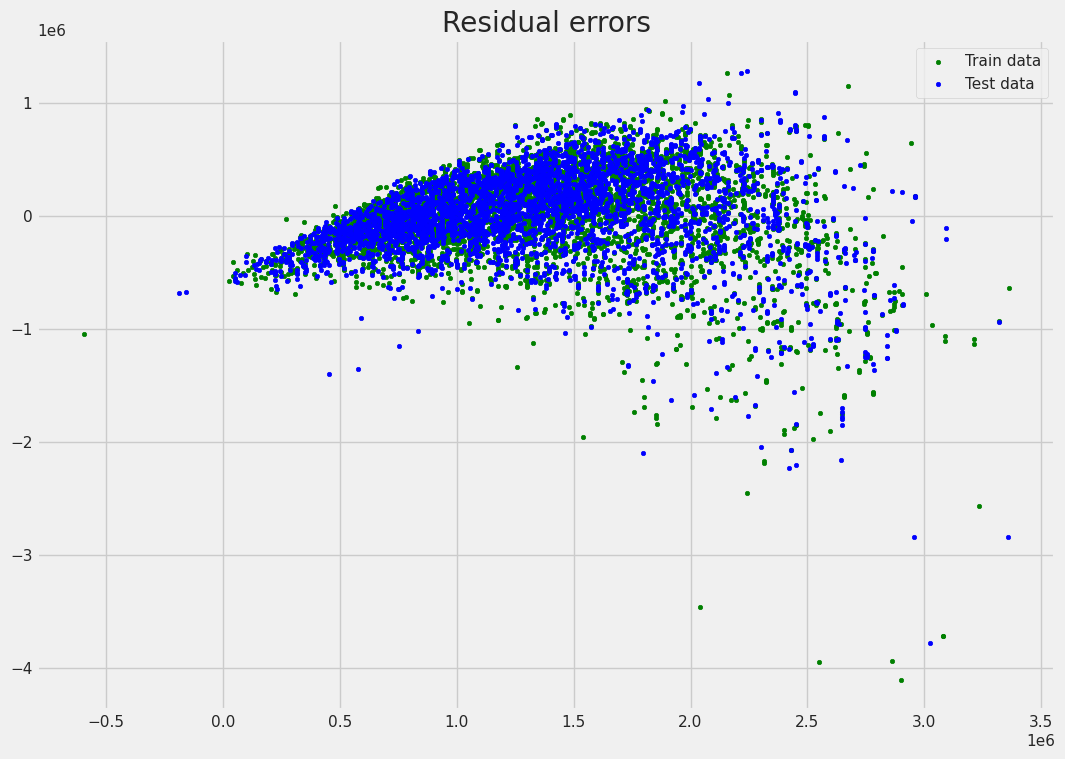

In [119]:
# plot for residual error

# setting plot style
plt.style.use('fivethirtyeight')

# plotting residual errors in training data
plt.scatter(reg.predict(X_train),
            reg.predict(X_train) - y_train,
            color="green", s=10,
            label='Train data')

# plotting residual errors in test data
plt.scatter(reg.predict(X_test),
            reg.predict(X_test) - y_test,
            color="blue", s=10,
            label='Test data')

# plotting line for zero residual error
plt.hlines(y=0, xmin=0, xmax=50, linewidth=2)

# plotting legend
plt.legend(loc='upper right')

# plot title
plt.title("Residual errors")

# method call for showing the plot
plt.show()

In [122]:
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.2, random_state=40)

In [126]:
rf_clf = RandomForestClassifier(random_state=40)
rf_clf.fit(X_train, y_train)

RandomForestClassifier(random_state=40)

In [127]:
y_pred = rf_clf.predict(X_test)

In [130]:
y_pred

array([ 819000, 1729000, 1779000, ..., 1749000,  559000, 1439000])

In [129]:
y_test

2340     849000
7624    1649000
8087    1799000
8056    1799000
5798    1289000
         ...   
7704    1669000
7455    1599000
8284    1889000
369      599000
6718    1429000
Name: price, Length: 1985, dtype: int64

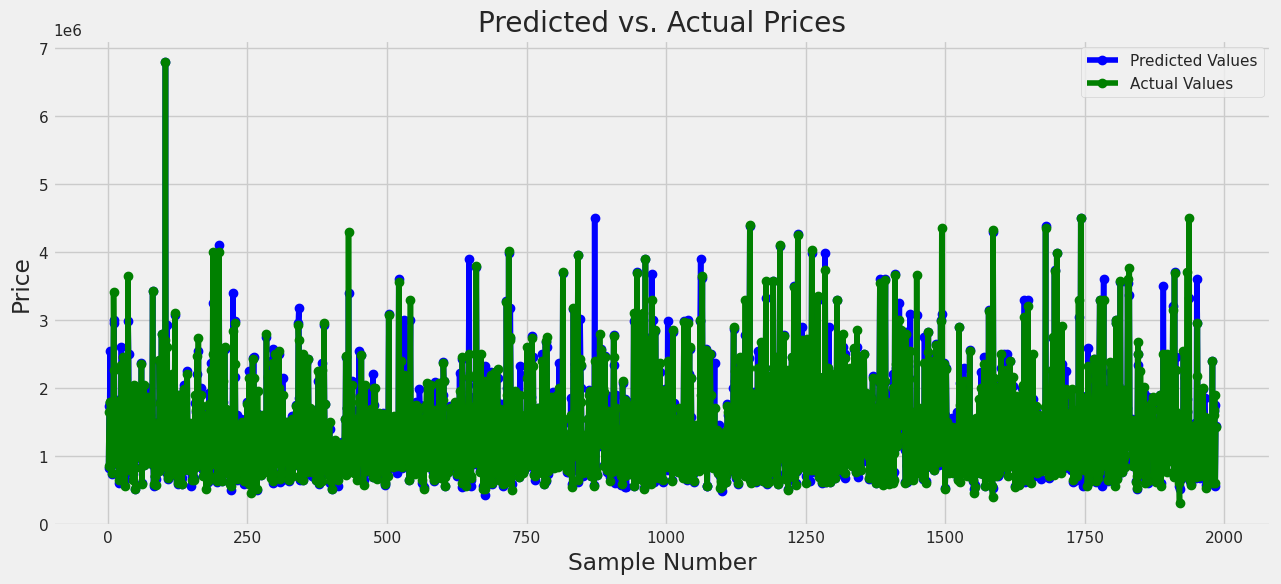

In [131]:
plt.figure(figsize=(14, 6))
plt.plot(np.arange(1, len(y_pred) + 1), y_pred, marker='o', linestyle='-', color='blue', label='Predicted Values')
plt.plot(np.arange(1, len(y_test) + 1), y_test.reset_index()['price'], marker='o', linestyle='-', color='green', label='Actual Values')
plt.xlabel("Sample Number") # Added x-axis label
plt.ylabel("Price") # Added y-axis label
plt.title("Predicted vs. Actual Prices") # Added title
plt.legend() # Added legend
plt.grid(True) # Added grid for better readability
plt.show()